In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from ephysvibe.trials.spikes import firing_rate,sp_constants
# from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.analysis import circular_stats
import os 
seed = 2023

In [2]:
def moving_average(data:np.ndarray,win:int,step:int=1)-> np.ndarray:
    d_shape=data.shape
    count = 0
    if len(d_shape) == 3:
        d_avg = np.zeros((d_shape[0],d_shape[1],int(np.floor(d_shape[2]/step))))
        for i_step in np.arange(0,d_shape[2]-win,step):
            d_avg[:,:,count] = np.mean(data[:,:,i_step:i_step+win],axis=2)
            count +=1
    if len(d_shape) == 2:
        d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
        for i_step in np.arange(0,d_shape[1]-win,step):
            d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
            count +=1
    if len(d_shape) == 1:
        d_avg = np.zeros((int(np.floor(d_shape[0]/step))))
        for i_step in np.arange(0,d_shape[0]-win,step):
            d_avg[count] = np.mean(data[i_step:i_step+win],axis=0)
            count +=1
    return d_avg

In [3]:
def get_task_variables(data:SpikeData,bhv:BhvData,in_out:str='in'):
    # Select trials (correct and DMTS task) and create task frame
    trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]

    if np.any(np.isnan(data.neuron_cond)):
        neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond=data.neuron_cond
    task = def_task.create_task_frame(
        condition=bhv.condition[trial_idx],
        test_stimuli=bhv.test_stimuli[trial_idx],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond = neuron_cond,
    )
    task = task[task['in_out']==in_out]
    return task, trial_idx

In [4]:
def get_trials_by_sample(task,feature,trial_idx,bhv,data):
    sample_trials = {"o1":np.array([]),"o5":np.array([]),"c1":np.array([]),"c5":np.array([])}
    
    for key_sample in sample_trials.keys():
        sample_trials[key_sample]=np.unique(task.loc[task['sample'].str.contains(key_sample, case=False)]['trial_idx'].values)

    test_stimuli = bhv.test_stimuli[trial_idx][sample_trials[feature]]
    code_numbers = data.code_numbers[trial_idx][sample_trials[feature]]
    code_samples = data.code_samples[trial_idx][sample_trials[feature]]
    sp_samples = data.sp_samples[trial_idx][sample_trials[feature]]
    return test_stimuli,code_numbers,code_samples,sp_samples,sample_trials

In [5]:
def delete_match(test_stimuli,code):
    code = (code-1).astype(int)
    tests_shape=test_stimuli.shape
    test_stimuli = np.concatenate([test_stimuli,np.ones((tests_shape[0],1))],axis=1)
    test_stimuli[np.arange(tests_shape[0]),code] =  np.nan
    test_stimuli = test_stimuli[:,:tests_shape[1]]
    return test_stimuli.astype(str)

In [6]:
def get_sample_avg_fr(task,sp_samples,test_stimuli,code_samples,color_orient:int=0):
    n_trials = np.zeros((8,4))
    samples_dicts = {"o1_c1":{},"o1_c5":{},"o5_c1":{},"o5_c5":{}}
    stim_num=['1','2','3','4','5','6','7','8']
    for i_sam,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
        task_sample = task[task['sample']==sample]
        test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
        # code_numbers_samp = code_numbers[task_sample['trial_idx']]
        code_samples_samp = code_samples[task_sample['trial_idx']]
        sp_samples_samp = sp_samples[task_sample['trial_idx']]

        test_stimuli_samp = delete_match(test_stimuli_samp)

        for i_num,i_stim in enumerate(stim_num):
            i_trial, i_test = np.where(np.char.find(test_stimuli_samp,i_stim)==color_orient)
            tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
            sp_stim = sp_samples_samp[i_trial]
            sp_tests = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 100:400]
            if np.isnan(np.sum(sp_tests)):
                raise ValueError('nan values')
            samples_dicts[sample][i_stim] = sp_tests.mean(axis=1)*1000
            n_trials[i_num,i_sam] =sp_tests.shape[0]

    return samples_dicts,n_trials

### Compute

In [7]:
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_bhv_lip.txt", "r")
lines_bhv = file1.readlines()
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_sp_lip.txt", "r")
lines_sp = file1.readlines()
# load all  files
paths_bhv,paths_sp=[],[]
for line in lines_bhv:
    paths_bhv.append(line.strip())
for line in lines_sp:
    paths_sp.append(line.strip())

### plots samples

In [8]:
orient = 0 
color = 1
n_iterations = 1000
win=100
step=1
samp_orient = (["o1_c1","o5_c1"],["o1_c5","o5_c5"])
samp_color = (["o1_c1","o1_c5"],["o5_c1","o5_c5"])

o_c = [color,color]
color_orient = color


In [9]:
paths_bhv[16:]

['/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-02-09_10-42-54_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-02-24_10-43-44_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-02-28_10-15-02_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-03-01_10-18-38_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-03-03_10-59-32_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-03-06_10-32-51_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-03-07_10-14-11_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-03-09_10-35-09_Riesling_e1_r1_bhv.h5',
 '/envau

In [10]:
# Neurons I checked
# path 10: 2022-12-16_10-30-59 i_neuron:4
# path 17: 2023-02-24_10-43-44 i_neuron:0 -> not significant
# path 16: 2023-02-09_10-42-54 i_neuron:2
# path 27: 2023-03-17_10-11-51 i_neuron:2
# path 28: 2023-03-20_10-39-08 i_neuron:10

In [11]:
# definir dataframe y agregar neurona y p value para cada orientacion
# selectivity_info: Dict[str, list] = defaultdict(list)

n_bhv=paths_bhv[16]
n_sp = paths_sp[16]
print(n_sp)
s_path = os.path.normpath(n_sp).split(os.sep)
date = s_path[-1][:19]
data = SpikeData.from_python_hdf5(n_sp)
bhv = BhvData.from_python_hdf5(n_bhv)

/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/lip/spikes/2023-02-09_10-42-54_Riesling_lip_e1_r1_sp.h5


In [12]:
all_task, all_trial_idx = get_task_variables(data,bhv,in_out='in')

In [13]:
all_task.head()

,i_neuron,trial_idx,sample,in_out,n_test_stimuli,code
0,0,3,o1_c1,in,2,2
1,0,9,o1_c1,in,2,2
2,0,11,o1_c1,in,2,2
3,0,18,o1_c1,in,2,2
4,0,46,o1_c1,in,2,2


In [14]:
data.clustersgroup

array(['good', 'good', 'good', 'mua'], dtype='<U4')

In [15]:
i_neuron = 2

In [16]:
task_tr = np.unique(all_task['trial_idx'].values)
trial_idx = task_tr[np.nansum(data.sp_samples[all_trial_idx[task_tr],i_neuron],axis=1)>0]
task = all_task[np.in1d(all_task['trial_idx'] , trial_idx)]
task=task[task['i_neuron']==i_neuron]

test_stimuli = bhv.test_stimuli[all_trial_idx]
code_numbers = data.code_numbers[all_trial_idx]
code_samples = data.code_samples[all_trial_idx]
sp_samples = data.sp_samples[all_trial_idx,i_neuron]

### Plot response by samples

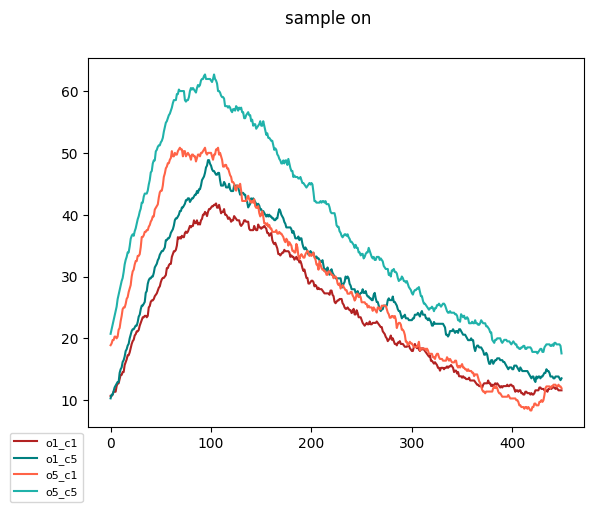

In [17]:
len_s_on=450
win=100
stim_num=['1','2','3','4','5','6','7','8']
all_sp_sample_on = np.zeros((4,len_s_on+win))
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]

    sp_sample_on = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,4].astype(int), axis=1)[:, :len_s_on+win]
    all_sp_sample_on[i] = sp_sample_on.mean(axis=0)
fig,ax = plt.subplots()
for sample,sp_sample in zip(["o1_c1","o1_c5","o5_c1","o5_c5"],all_sp_sample_on):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:450],label=sample,color=task_constants.PALETTE_B1[sample])
fig.suptitle('sample on')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})


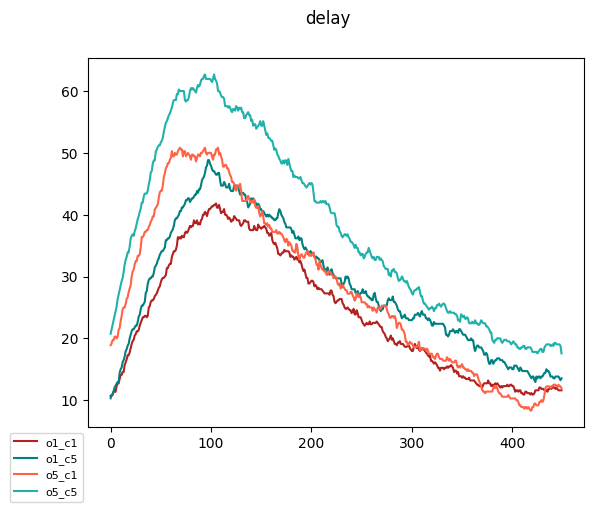

In [18]:
len_d_on=450
win=100
all_sp_delay = np.zeros((4,len_d_on+win))
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]

    sp_delay = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,5].astype(int), axis=1)[:, :len_d_on+win]
    all_sp_delay[i] = sp_delay.mean(axis=0)

fig,ax = plt.subplots()
for sample,sp_sample in zip(["o1_c1","o1_c5","o5_c1","o5_c5"],all_sp_sample_on):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:450],label=sample,color=task_constants.PALETTE_B1[sample])
fig.suptitle('delay')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

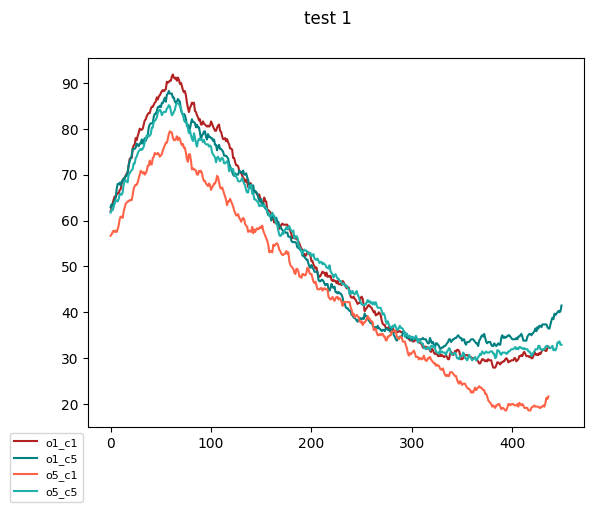

In [19]:
len_t1_on=450
win=100
all_sp_test1 = np.zeros((4,len_t1_on+win))
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]

    sp_test1 = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,6].astype(int), axis=1)[:, :len_t1_on+win]
    all_sp_test1[i] = sp_test1.mean(axis=0)

fig,ax = plt.subplots()
for sample,sp_sample in zip(["o1_c1","o1_c5","o5_c1","o5_c5"],all_sp_test1):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:450],label=sample,color=task_constants.PALETTE_B1[sample])
fig.suptitle('test 1')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

### Plot response by feature (color 1, color 5, orientation 1, orientation 5)

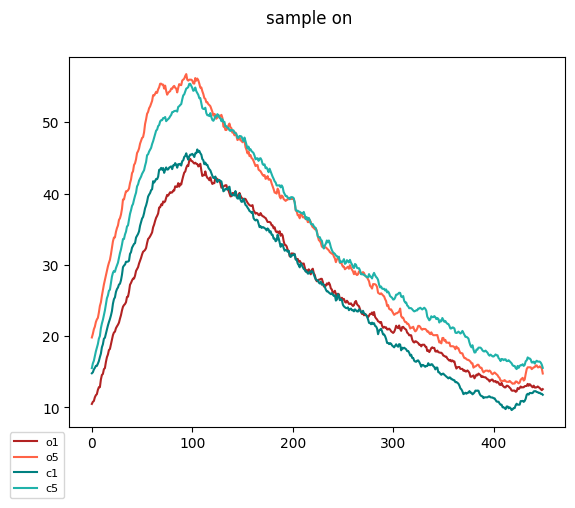

In [20]:
len_s_on=450
win=100
all_sp_sample_on = np.zeros((4,len_s_on+win))
all_feature_s_on_avg = []
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]

    sp_sample_on = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,4].astype(int), axis=1)[:, :len_s_on+win]
    all_sp_sample_on[i] = sp_sample_on.mean(axis=0)
o1 = np.mean([all_sp_sample_on[0],all_sp_sample_on[1]],axis=0)
o5 = np.mean([all_sp_sample_on[2],all_sp_sample_on[3]],axis=0)
c1 = np.mean([all_sp_sample_on[0],all_sp_sample_on[2]],axis=0)
c5 = np.mean([all_sp_sample_on[1],all_sp_sample_on[3]],axis=0)

fig,ax = plt.subplots()
for i,(sample,sp_sample) in enumerate(zip(["o1_c1","o5_c1","o1_c5","o5_c5"],[o1,o5,c1,c5])):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:450],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample])
    all_feature_s_on_avg.append(sample_avg[:450])
fig.suptitle('sample on')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

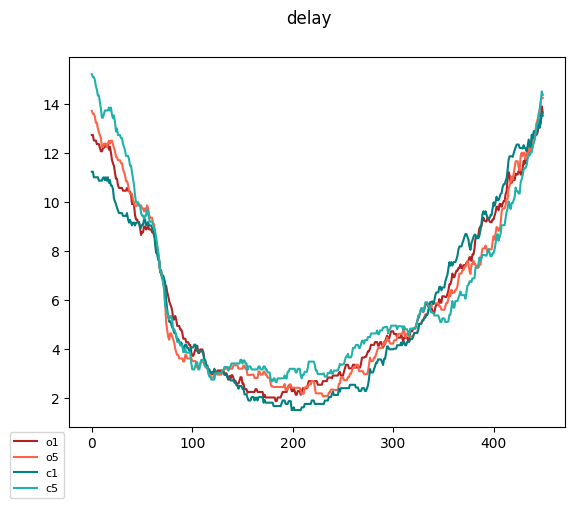

In [21]:
len_d_on=450
win=100
all_sp_delay = np.zeros((4,len_d_on+win))
all_feature_delay_avg = []
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]

    sp_delay = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,5].astype(int), axis=1)[:, :len_d_on+win]
    all_sp_delay[i] = sp_delay.mean(axis=0)

o1 = np.mean([all_sp_delay[0],all_sp_delay[1]],axis=0)
o5 = np.mean([all_sp_delay[2],all_sp_delay[3]],axis=0)
c1 = np.mean([all_sp_delay[0],all_sp_delay[2]],axis=0)
c5 = np.mean([all_sp_delay[1],all_sp_delay[3]],axis=0)

fig,ax = plt.subplots()
for i,(sample,sp_sample) in enumerate(zip(["o1_c1","o5_c1","o1_c5","o5_c5"],[o1,o5,c1,c5])):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample])
    all_feature_delay_avg.append(sample_avg[:len_d_on])
fig.suptitle('delay')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

/tmp/ipykernel_122839/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


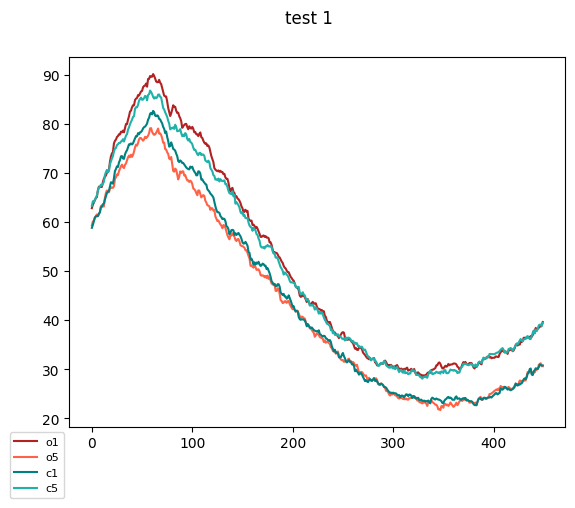

In [22]:
len_t1_on=450
win=100
all_sp_test1 = np.zeros((4,len_t1_on+win))
all_feature_t1_avg = []
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    idx = np.where(test_stimuli_samp[:,0]!='nan')[0]

    sp_test1 = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,6].astype(int), axis=1)[:, :len_t1_on+win]
    all_sp_test1[i] = sp_test1.mean(axis=0)

o1 = np.mean([all_sp_test1[0],all_sp_test1[1]],axis=0)
o5 = np.mean([all_sp_test1[2],all_sp_test1[3]],axis=0)
c1 = np.mean([all_sp_test1[0],all_sp_test1[2]],axis=0)
c5 = np.mean([all_sp_test1[1],all_sp_test1[3]],axis=0)

fig,ax = plt.subplots()
for i,(sample,sp_sample) in enumerate(zip(["o1_c1","o5_c1","o1_c5","o5_c5"],[o1,o5,c1,c5])):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample])
    all_feature_t1_avg.append(sample_avg[:len_d_on])
fig.suptitle('test 1')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

/tmp/ipykernel_122839/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


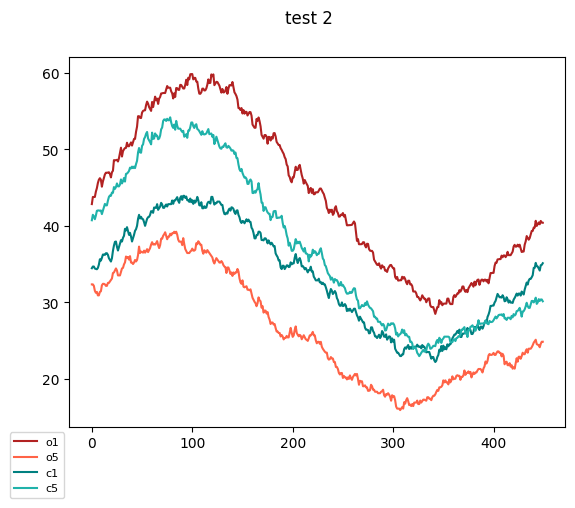

In [23]:
len_t2_on=450
win=100
all_sp_test2 = np.zeros((4,len_t2_on+win))
all_feature_t2_avg = []
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    idx = np.where(test_stimuli_samp[:,1]!='nan')[0]

    sp_test1 = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,8].astype(int), axis=1)[:, :len_t2_on+win]

    all_sp_test2[i] = sp_test1.mean(axis=0)

o1 = np.mean([all_sp_test2[0],all_sp_test2[1]],axis=0)
o5 = np.mean([all_sp_test2[2],all_sp_test2[3]],axis=0)
c1 = np.mean([all_sp_test2[0],all_sp_test2[2]],axis=0)
c5 = np.mean([all_sp_test2[1],all_sp_test2[3]],axis=0)

fig,ax = plt.subplots()
for i,(sample,sp_sample) in enumerate(zip(["o1_c1","o5_c1","o1_c5","o5_c5"],[o1,o5,c1,c5])):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample])
    all_feature_t2_avg.append(sample_avg[:len_d_on])
fig.suptitle('test 2')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

/tmp/ipykernel_122839/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


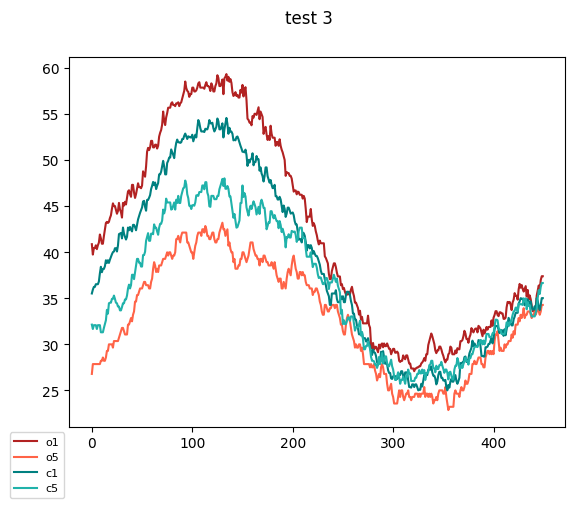

In [24]:
len_t2_on=450
win=100
all_sp_test2 = np.zeros((4,len_t2_on+win))
all_feature_t3_avg = []
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    idx = np.where(test_stimuli_samp[:,2]!='nan')[0]
    sp_test1 = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,10].astype(int), axis=1)[:, :len_t2_on+win]    
    all_sp_test2[i] = sp_test1.mean(axis=0)

o1 = np.mean([all_sp_test2[0],all_sp_test2[1]],axis=0)
o5 = np.mean([all_sp_test2[2],all_sp_test2[3]],axis=0)
c1 = np.mean([all_sp_test2[0],all_sp_test2[2]],axis=0)
c5 = np.mean([all_sp_test2[1],all_sp_test2[3]],axis=0)

fig,ax = plt.subplots()
for i,(sample,sp_sample) in enumerate(zip(["o1_c1","o5_c1","o1_c5","o5_c5"],[o1,o5,c1,c5])):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample])
    all_feature_t3_avg.append(sample_avg[:len_d_on])
fig.suptitle('test 3')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

/tmp/ipykernel_122839/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


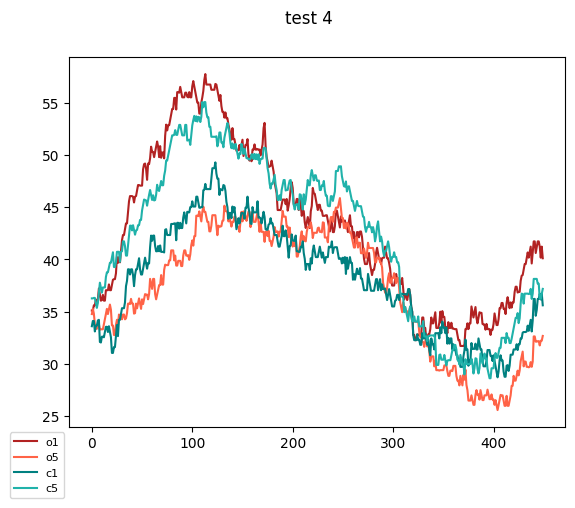

In [25]:
len_t2_on=450
win=100
all_sp_test2 = np.zeros((4,len_t2_on+win))
all_feature_t4_avg= []
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    idx = np.where(test_stimuli_samp[:,3]!='nan')[0]
    
    sp_test1 = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,12].astype(int), axis=1)[:, :len_t2_on+win]
    all_sp_test2[i] = sp_test1.mean(axis=0)

o1 = np.mean([all_sp_test2[0],all_sp_test2[1]],axis=0)
o5 = np.mean([all_sp_test2[2],all_sp_test2[3]],axis=0)
c1 = np.mean([all_sp_test2[0],all_sp_test2[2]],axis=0)
c5 = np.mean([all_sp_test2[1],all_sp_test2[3]],axis=0)

fig,ax = plt.subplots()
for i,(sample,sp_sample) in enumerate(zip(["o1_c1","o5_c1","o1_c5","o5_c5"],[o1,o5,c1,c5])):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample])
    all_feature_t4_avg.append(sample_avg[:len_d_on])
fig.suptitle('test 4')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

/tmp/ipykernel_122839/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


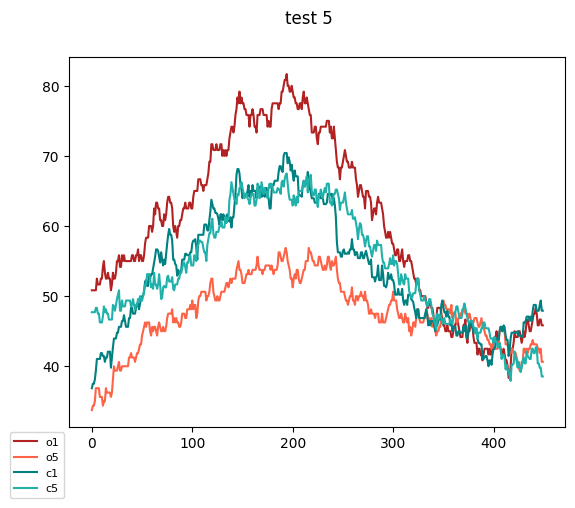

In [26]:
len_t2_on=450
win=100
all_sp_test2 = np.zeros((4,len_t2_on+win))
all_feature_t5_avg=[]
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    idx = np.where(test_stimuli_samp[:,4]!='nan')[0]
    
    sp_test1 = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,14].astype(int), axis=1)[:, :len_t2_on+win]
    all_sp_test2[i] = sp_test1.mean(axis=0)

o1 = np.mean([all_sp_test2[0],all_sp_test2[1]],axis=0)
o5 = np.mean([all_sp_test2[2],all_sp_test2[3]],axis=0)
c1 = np.mean([all_sp_test2[0],all_sp_test2[2]],axis=0)
c5 = np.mean([all_sp_test2[1],all_sp_test2[3]],axis=0)

fig,ax = plt.subplots()
for i,(sample,sp_sample) in enumerate(zip(["o1_c1","o5_c1","o1_c5","o5_c5"],[o1,o5,c1,c5])):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample])
    all_feature_t5_avg.append(sample_avg[:len_d_on])
fig.suptitle('test 5')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

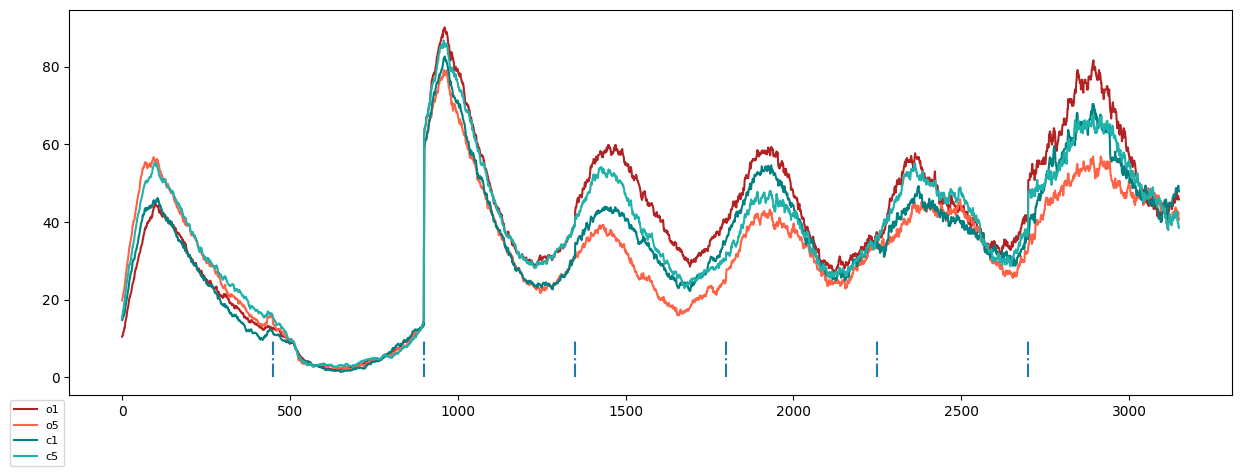

In [27]:
all_trial = np.concatenate([all_feature_s_on_avg,all_feature_delay_avg,all_feature_t1_avg,all_feature_t2_avg,all_feature_t3_avg,all_feature_t4_avg,all_feature_t5_avg],axis=1)
sample=["o1_c1","o5_c1","o1_c5","o5_c5"]
fig,ax=plt.subplots(figsize=(15,5))
for i in range(4):
    ax.plot(all_trial[i],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample[i]])
ax.vlines([450,450*2,450*3,450*4,450*5,450*6],[0,0,0,0,0,0],[10,10,10,10,10,10],linestyles='-.')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

## ff

In [28]:
def get_sp_feature(sp_samples_samp,test_stimuli_samp,code_samples_samp,color_orient,stim_num):
    all_sp_tests=[]
    for i_num,i_stim in enumerate(stim_num):
        i_trial, i_test = np.where(np.char.find(test_stimuli_samp,i_stim)==color_orient)
        tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
        sp_stim = sp_samples_samp[i_trial]
        sp_tests = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]
        if np.isnan(np.sum(sp_tests)):
            raise ValueError('nan values')
        all_sp_tests.append(sp_tests)
    return all_sp_tests

In [29]:
len_t1_on=450
win=100
stim_num=['1','2','3','4','5','6','7','8']
all_sp_test1 = np.zeros((4,len_t1_on+win))

all_sample_feature = {"o1_c1":{"color":[],"orientation":[]},"o1_c5":{"color":[],"orientation":[]},"o5_c1":{"color":[],"orientation":[]},"o5_c5":{"color":[],"orientation":[]}}
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):

    
    task_sample = task[task['sample']==sample]
    trials = task_sample['trial_idx'].values
    test_stimuli_samp = test_stimuli[trials]
    code_numbers_samp = code_numbers[trials]
    code_samples_samp = code_samples[trials]
    sp_samples_samp = sp_samples[trials]
    
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)

    color_tests = get_sp_feature(sp_samples_samp,test_stimuli_samp,code_samples_samp,color_orient=color,stim_num=stim_num)
    orient_tests = get_sp_feature(sp_samples_samp,test_stimuli_samp,code_samples_samp,color_orient=orient,stim_num=stim_num)

    all_sample_feature[sample]["color"]= color_tests
    all_sample_feature[sample]["orientation"]= orient_tests

/tmp/ipykernel_122839/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


In [30]:
o1 = []
o5 = []
c1 = []
c5 = []
for i in range(8):
    o1.append(np.concatenate([all_sample_feature["o1_c1"]['orientation'][i],all_sample_feature["o1_c5"]['orientation'][i]],axis=0))
    print("o1 - o%d n trials: %d"%(i,o1[i].shape[0]))
    o5.append(np.concatenate([all_sample_feature["o5_c1"]['orientation'][i],all_sample_feature["o5_c5"]['orientation'][i]],axis=0))
    print("o5 - o%d n trials: %d"%(i,o5[i].shape[0]))
    c1.append(np.concatenate([all_sample_feature["o1_c1"]['color'][i],all_sample_feature["o5_c1"]['color'][i]],axis=0))
    print("c1 - c%d n trials: %d"%(i,c1[i].shape[0]))
    c5.append(np.concatenate([all_sample_feature["o1_c5"]['color'][i],all_sample_feature["o5_c5"]['color'][i]],axis=0))
    print("c5 - c%d n trials: %d"%(i,c5[i].shape[0]))

o1 - o0 n trials: 49
o5 - o0 n trials: 36
c1 - c0 n trials: 44
c5 - c0 n trials: 23
o1 - o1 n trials: 13
o5 - o1 n trials: 12
c1 - c1 n trials: 16
c5 - c1 n trials: 6
o1 - o2 n trials: 14
o5 - o2 n trials: 11
c1 - c2 n trials: 9
c5 - c2 n trials: 8
o1 - o3 n trials: 14
o5 - o3 n trials: 17
c1 - c3 n trials: 11
c5 - c3 n trials: 14
o1 - o4 n trials: 38
o5 - o4 n trials: 51
c1 - c4 n trials: 22
c5 - c4 n trials: 50
o1 - o5 n trials: 11
o5 - o5 n trials: 17
c1 - c5 n trials: 17
c5 - c5 n trials: 11
o1 - o6 n trials: 19
o5 - o6 n trials: 10
c1 - c6 n trials: 18
c5 - c6 n trials: 11
o1 - o7 n trials: 15
o5 - o7 n trials: 18
c1 - c7 n trials: 14
c5 - c7 n trials: 16


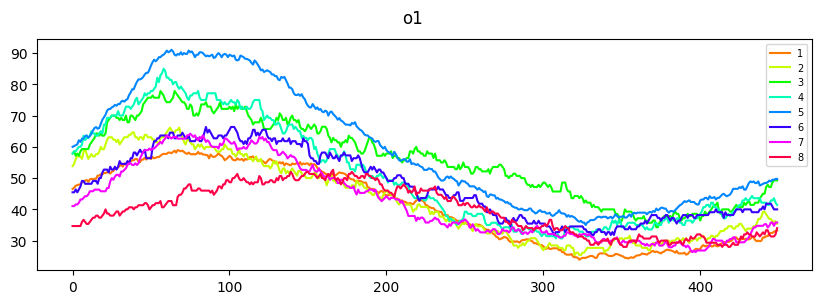

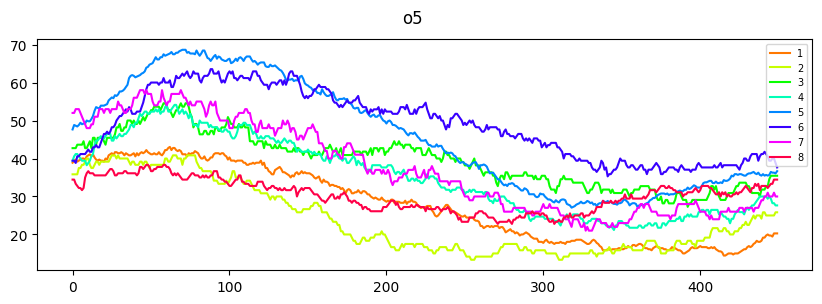

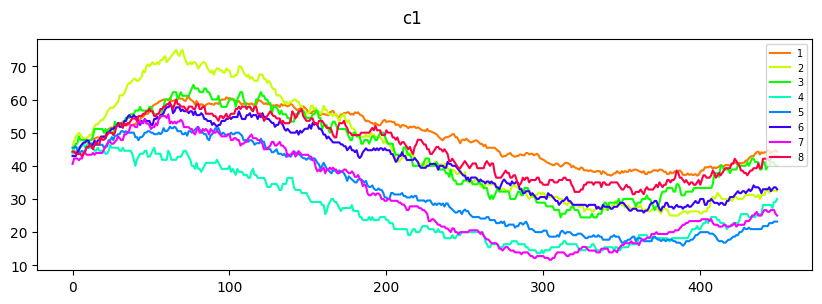

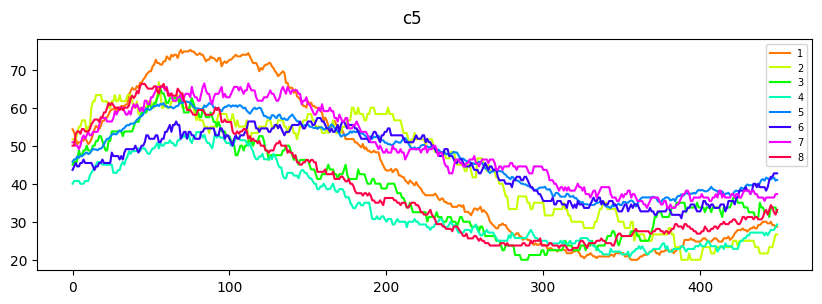

In [31]:
palette = plt.get_cmap('hsv',64)

fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(o1):
    o_i = o_i.mean(axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=stim_num[i],color=palette(i*8+5))
    fig.suptitle('o1')
    plt.legend( prop={'size': 7})
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(o5):
    o_i = o_i.mean(axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=stim_num[i],color=palette(i*8+5))
    fig.suptitle('o5')
    plt.legend( prop={'size': 7})
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(c1):
    o_i = o_i.mean(axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=stim_num[i],color=palette(i*8+5))
    fig.suptitle('c1')
    plt.legend( prop={'size': 7})
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(c5):
    o_i = o_i.mean(axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=stim_num[i],color=palette(i*8+5))
    fig.suptitle('c5')
    plt.legend( prop={'size': 7})

In [32]:
# plt.plot(o5[5].mean(axis=0))
# plt.plot(moving_average(data=o5[5].mean(axis=0),win=win,step=1))
# plt.plot(o5[0].mean(axis=0))
# plt.plot(moving_average(data=o5[0].mean(axis=0),win=win,step=1))

In [50]:
o1[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

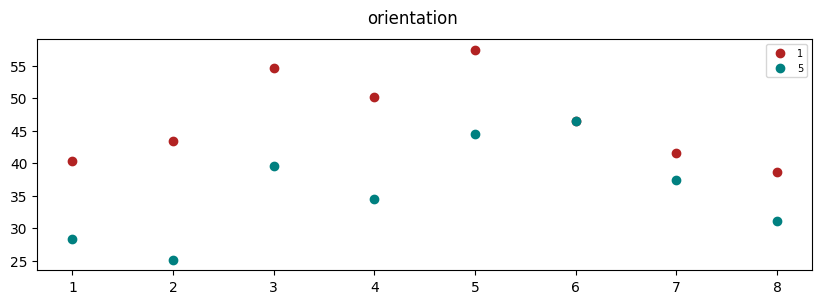

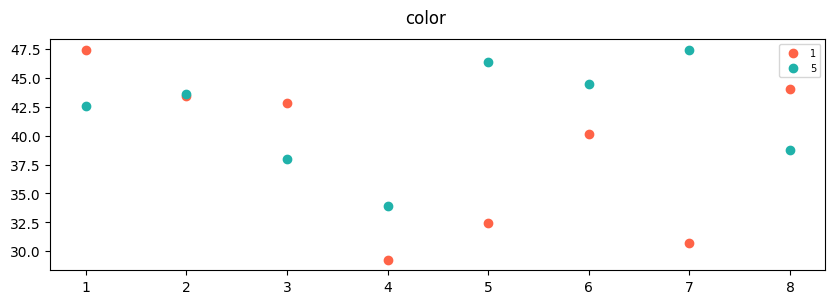

In [74]:
sample=["o1_c1","o5_c1","o1_c5","o5_c5"]
fig,ax = plt.subplots(figsize=(10,3))
o1_i_all=[]
o5_i_all=[]
for i, (o1_i,o5_i) in enumerate(zip(o1,o5)):
    o1_i_all.append(o1_i.mean()*1000)
    o5_i_all.append(o5_i.mean()*1000)
    
ax.scatter(range(1,9),o1_i_all,color=task_constants.PALETTE_B1[sample[0]],label='1')
ax.scatter(range(1,9),o5_i_all,color=task_constants.PALETTE_B1[sample[2]],label='5')
fig.suptitle('orientation')
ax.legend( prop={'size': 7})

fig,ax = plt.subplots(figsize=(10,3))
c1_i_all=[]
c5_i_all=[]
for i, (c1_i,c5_i) in enumerate(zip(c1,c5)):
    c1_i_all.append(c1_i.mean()*1000)
    c5_i_all.append(c5_i.mean()*1000)
    
ax.scatter(range(1,9),c1_i_all,color=task_constants.PALETTE_B1[sample[1]],label='1')
ax.scatter(range(1,9),c5_i_all,color=task_constants.PALETTE_B1[sample[3]],label='5')
fig.suptitle('color')
ax.legend( prop={'size': 7})

## Check if selective to color or orientation

In [33]:
o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg=[],[],[],[]
n_trials=[]
for i in range(8):
    n_tr=[]
    avg = o1[i].mean(axis=1)*1000
    o1_trial_avg.append(avg)
    n_tr.append(len(avg))
    avg = o5[i].mean(axis=1)*1000
    o5_trial_avg.append(avg)
    n_tr.append(len(avg))
    avg = c1[i].mean(axis=1)*1000
    c1_trial_avg.append(avg)
    n_tr.append(len(avg))
    avg = c5[i].mean(axis=1)*1000
    c5_trial_avg.append(avg)
    n_tr.append(len(avg))
    n_trials.append(n_tr)

In [34]:
n_trials

[[49, 36, 44, 23],
 [13, 12, 16, 6],
 [14, 11, 9, 8],
 [14, 17, 11, 14],
 [38, 51, 22, 50],
 [11, 17, 17, 11],
 [19, 10, 18, 11],
 [15, 18, 14, 16]]

#### Def funct

In [35]:
def select_rand_trials_from_samples(trials_fr,min_n_trials,seed:int=1,n_iterations:int=1000):
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=10000, size=n_iterations, dtype=int)
    stim_num=['1','2','3','4','5','6','7','8']
    stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
    mean_select=[]
    for n_it in range(n_iterations):
        np.random.seed(it_seed[n_it]) 
        mean_resp = np.zeros((8,2))
        for i_num,i_stim in enumerate(stim_num):
            fr = np.random.choice(trials_fr[i_num], size=min_n_trials[i_num], replace=True, p=None)
            mean_resp[i_num] = circular_stats.mean_vector(fr, [stim_angle[i_num]]*len(fr))
        mean_select.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,1]) )
    mean_select=np.array(mean_select)
    return mean_select

In [36]:
def get_null_vector_from_samples(trials_fr,min_n_trials,seed:int=1,n_iterations:int=1000):
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=10000, size=n_iterations, dtype=int)
    stim_num=['1','2','3','4','5','6','7','8']
    stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
    mean_select=[]

    for n_it in range(n_iterations):
        all_sample1 = []
        
        np.random.seed(it_seed[n_it]) 
        for i_num,i_stim in enumerate(stim_num):
            all_sample1.append(np.random.choice(trials_fr[i_num], size=min_n_trials[i_num], replace=False, p=None))
        all_sample1 = np.concatenate(all_sample1)
       
        mean_resp = np.zeros((8,2))
        for i_num,i_stim in enumerate(stim_num):
            fr = np.random.choice(all_sample1, size=min_n_trials[i_num], replace=True, p=None)

            mean_resp[i_num] = circular_stats.mean_vector(fr, [stim_angle[i_num]]*len(fr))
        mean_select.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,1]) )
    mean_select=np.array(mean_select)
    return mean_select

In [37]:
## Permutation test
def permutation_test(mean_select,mean_null):
    radius = mean_select[:,0]
    angle =  mean_select[:,1]
    X = (np.array(radius) * np.cos(angle))
    Y = (np.array(radius) * np.sin(angle))
    ampl_dir_vector = np.sqrt(X**2+Y**2)
    radius = mean_null[:,0]
    angle =  mean_null[:,1]
    X = (np.array(radius) * np.cos(angle))
    Y = (np.array(radius) * np.sin(angle))
    ampl_null_vector = np.sqrt(X**2+Y**2)
    diff=[]
    for i in range(len(ampl_dir_vector)):
        shift = np.concatenate([ampl_dir_vector[i:],ampl_dir_vector[:i]])
        diff.append(shift-ampl_null_vector)
    diff=np.concatenate(diff)
    p_value = np.sum(diff<0)/len(diff)
    return p_value

### Plot

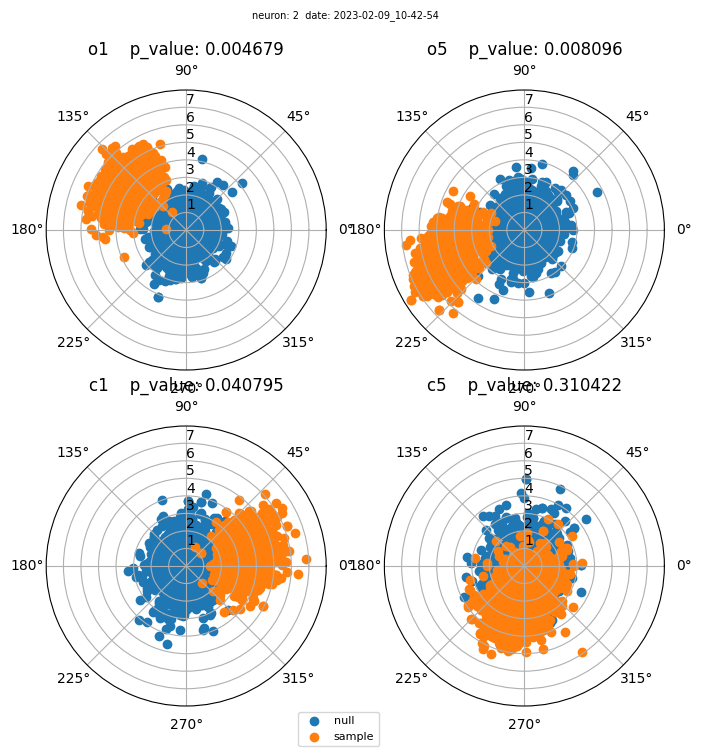

In [38]:
# definir dataframe y agregar neurona y p value para cada orientacion
selectivity_info: Dict[str, list] = defaultdict(list)

min_n_trials = np.min(n_trials,axis=1).astype(int)
all_select = []
all_null=[]
all_p_value=[]
for trial_avg,feature in zip([o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg],['o1','o5','c1','c5']):

    if np.sum(min_n_trials<3)>0:
        p_value = np.nan
        mean_null = np.zeros((2,2))
        mean_select = np.zeros((2,2))
    else:
        mean_select = select_rand_trials_from_samples(trial_avg,min_n_trials,seed,n_iterations=1000)
        mean_null = get_null_vector_from_samples(trial_avg,min_n_trials,seed,n_iterations=1000)
        p_value = permutation_test(mean_select,mean_null)

    all_select.append(mean_select)
    all_null.append(mean_null)
    all_p_value.append(p_value)
    selectivity_info['date'] += [date]
    selectivity_info['i_neuron'] += [i_neuron]
    selectivity_info['neuron_type'] += [data.clustersgroup[i_neuron]]
    selectivity_info['p_value'] += [p_value]
    selectivity_info['sample1'] += [feature]


selectivity_info = pd.DataFrame(selectivity_info) 

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True,subplot_kw={'projection': 'polar'})
for i,(ax, feature)in enumerate(zip([ax1,ax2,ax3,ax4],['o1','o5','c1','c5'])):
    ax.set_rlabel_position(90)
    ax.scatter(all_null[i][:,1],all_null[i][:,0],label='null')
    ax.scatter(all_select[i][:,1],all_select[i][:,0],label='sample')
    ax.set_title('%s    p_value: %f'%(feature,all_p_value[i]) )
fig.suptitle('neuron: %d  date: %s'%(i_neuron,date),fontsize=7)

plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

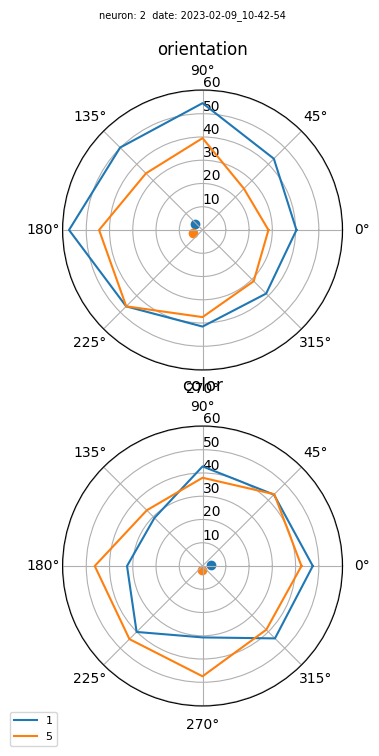

In [39]:
stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
min_n_trials = np.min(n_trials,axis=1).astype(int)
dir_vector = []
all_mean_resp=[]
for trial_avg,feature in zip([o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg],['o1','o5','c1','c5']):
    if np.sum(min_n_trials<3)>0:
        p_value = np.nan
        mean_null = np.zeros((2,2))
        mean_select = np.zeros((2,2))
    else:
        mean_select=[]
        mean_resp = np.zeros((8,3))
        for i_num in range(8):
            fr = trial_avg[i_num]
            mean_resp[i_num] = [np.mean(fr),np.std(fr),stim_angle[i_num]]
    dir_vector.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,2]))
    all_mean_resp.append(mean_resp)
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8),sharex=True,sharey=True,subplot_kw={'projection': 'polar'})
for i,(ax, feature)in enumerate(zip([ax1,ax1,ax2,ax2],['o1','o5','c1','c5'])):
    ax.set_rlabel_position(90)
    mean_angle = np.concatenate([all_mean_resp[i][:,2],[all_mean_resp[i][0,2]]])
    mean_fr = np.concatenate([all_mean_resp[i][:,0],[all_mean_resp[i][0,0]]])
    ax.plot(mean_angle, mean_fr ,label=['1','5','1','5'][i])
    ax.scatter(dir_vector[i][1],dir_vector[i][0])
    title = 'color'
    if feature in ['o1','o5']:
        title = 'orientation'
    #ax.plot(all_mean_resp[i][:,2],all_mean_resp[i][:,0]+all_mean_resp[i][:,1],label='std')
    ax.set_title(title)
fig.suptitle('neuron: %d  date: %s'%(i_neuron,date),fontsize=7)

plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

In [41]:
mean_resp

array([[42.52964427, 15.24728853,  0.        ],
       [43.63636364, 20.83650114,  0.78539816],
       [37.95454545, 13.0300828 ,  1.57079633],
       [33.8961039 ,  8.76310671,  2.35619449],
       [46.36363636, 14.78998991,  3.14159265],
       [44.46280992, 13.39149031,  3.92699082],
       [47.43801653, 17.16940906,  4.71238898],
       [38.75      , 14.02062751,  5.49778714]])

In [42]:
print(circular_stats.mean_vector(all_mean_resp[0][:,0], all_mean_resp[0][:,2]))
print(circular_stats.mean_vector(all_mean_resp[1][:,0], all_mean_resp[1][:,2]))
print(circular_stats.mean_vector(all_mean_resp[2][:,0], all_mean_resp[2][:,2]))
print(circular_stats.mean_vector(all_mean_resp[3][:,0], all_mean_resp[3][:,2]))

(4.156666553558152, 2.5357835022546102)
(4.399215811954112, 3.448565423714151)
(3.4981572209531415, 0.1438701680712431)
(1.692006267818907, 4.639470406399555)


In [43]:
print(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,2]))

(1.692006267818907, 4.639470406399555)


In [73]:
4.639470406399555*180/np.pi

265.8220734625393

In [45]:
dir_vector

[(4.156666553558152, 2.5357835022546102),
 (4.399215811954112, 3.448565423714151),
 (3.4981572209531415, 0.1438701680712431),
 (1.692006267818907, 4.639470406399555)]

In [46]:
fr

array([23.63636364, 23.63636364, 40.        , 47.27272727, 43.63636364,
       60.        , 49.09090909, 27.27272727, 41.81818182, 52.72727273,
       20.        , 21.81818182, 67.27272727, 36.36363636, 23.63636364,
       41.81818182])